# Cell 1: Install Packages


In [ ]:
!pip install --quiet tensorflow tensorflow_federated pandas openpyxl scikit-learn matplotlib


# Cell 2: Upload Dataset

In [ ]:
# from google.colab import files
# uploaded = files.upload()


Saving HV Circuit Breaker Maintenance Data.xlsx to HV Circuit Breaker Maintenance Data (1).xlsx


# Cell 3: Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import matplotlib.pyplot as plt

# Load dataset
# filename = next(iter(uploaded))
df = pd.read_excel("Emergency Station Generator Maintenance Data.xlsx")

# Clean and encode
df = df.dropna(thresh=len(df) * 0.5, axis=1).dropna()
df = pd.get_dummies(df, columns=['genset_supplying_load', 'transfer_switch_status'])

# Extract labels and scale features
y = df['Maintenance_required']
X = df.drop(columns=['Maintenance_required', 'Product_variant'])  # Drop 'Product_variant'

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Final combined dataset
df_final = X_scaled.copy()
df_final['Maintenance_required'] = y.values


# Cell 4A: Create Dirichlet Non-IID Client Partition


In [ ]:
def create_dirichlet_non_iid(df, num_clients=5, alpha=0.5, label_col='Maintenance_required'):
    label_indices = {}
    for label in df[label_col].unique():
        label_indices[label] = np.where(df[label_col] == label)[0]

    client_indices = [[] for _ in range(num_clients)]
    for label, indices in label_indices.items():
        np.random.shuffle(indices)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = (np.cumsum(proportions) * len(indices)).astype(int)[:-1]
        splits = np.split(indices, proportions)
        for client_id, idx in enumerate(splits):
            client_indices[client_id] += idx.tolist()

    client_datasets = []
    for client_idx in client_indices:
        df_client = df.iloc[client_idx]
        labels = df_client.pop(label_col)
        dataset = tf.data.Dataset.from_tensor_slices((OrderedDict(df_client.items()), labels)).shuffle(100).batch(10)
        client_datasets.append(dataset)
    return client_datasets

dirichlet_clients = create_dirichlet_non_iid(df_final, num_clients=5, alpha=0.5)


 # Cell 4B: Create Feature Skew Non-IID Client Partition

In [ ]:
def create_feature_skew_non_iid(df, num_clients=5, feature='engine_temperature', label_col='Maintenance_required'):
    df_sorted = df.sort_values(by=feature)
    client_dataframes = np.array_split(df_sorted, num_clients)
    client_datasets = []
    for df_client in client_dataframes:
        labels = df_client.pop(label_col)
        dataset = tf.data.Dataset.from_tensor_slices((OrderedDict(df_client.items()), labels)).shuffle(100).batch(10)
        client_datasets.append(dataset)
    return client_datasets

feature_skew_clients = create_feature_skew_non_iid(df_final, num_clients=5)


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Cell 5: Model Definition

In [ ]:
def model_fn(input_spec):
    feature_spec = input_spec[0]
    inputs = {name: tf.keras.Input(shape=(1,), name=name) for name in feature_spec.keys()}
    x = tf.keras.layers.Concatenate()(list(inputs.values()))
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# Cell 6: Build Federated Algorithms Including FedProx and FedBN

In [ ]:
def build_fedavg(input_spec, momentum=0.0):
    def client_opt_fn():
        if momentum == 0.0:
            return tf.keras.optimizers.SGD(learning_rate=0.02)
        else:
            return tf.keras.optimizers.SGD(learning_rate=0.02, momentum=momentum)

    return tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=client_opt_fn,
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )

def build_fedprox(input_spec, proximal_mu=0.1):
    return tff.learning.algorithms.build_weighted_fed_prox(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
        proximal_strength=proximal_mu
    )


def build_fedbn(input_spec):
    # Same as FedAvg, but with BatchNorm kept local
    return tff.learning.algorithms.build_weighted_fed_bn(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )


# Cell 7: Training Loop

In [ ]:
def train_process(algorithm, client_datasets, num_rounds=20):
    state = algorithm.initialize()
    acc_list = []
    for round_num in range(1, num_rounds + 1):
        state, metrics = algorithm.next(state, client_datasets)
        acc = metrics['client_work']['train']['binary_accuracy']
        acc_list.append(acc)
        print(f"Round {round_num}: Accuracy={acc:.4f}")
    return acc_list


# Cell 8: Compare Federated Algorithms (FedAvg versus FedAvgM only)


In [ ]:
def compare_algorithms(client_datasets, title):
    input_spec = client_datasets[0].element_spec

    fedavg = build_fedavg(input_spec)
    fedavg_momentum = build_fedavg(input_spec, momentum=0.9)

    acc_fedavg = train_process(fedavg, client_datasets)
    acc_fedavg_momentum = train_process(fedavg_momentum, client_datasets)

    rounds = list(range(1, len(acc_fedavg)+1))
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, acc_fedavg, label='FedAvg')
    plt.plot(rounds, acc_fedavg_momentum, label='FedAvg + Momentum')
    plt.title(f'Accuracy over Rounds - {title}')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()


# Cell 9: Run Comparisons

Round 1: Accuracy=0.7178
Round 2: Accuracy=0.7344
Round 3: Accuracy=0.7489
Round 4: Accuracy=0.7489
Round 5: Accuracy=0.7556
Round 6: Accuracy=0.7578
Round 7: Accuracy=0.7589
Round 8: Accuracy=0.7667
Round 9: Accuracy=0.7700
Round 10: Accuracy=0.7644
Round 11: Accuracy=0.7700
Round 12: Accuracy=0.7744
Round 13: Accuracy=0.7811
Round 14: Accuracy=0.7711
Round 15: Accuracy=0.7789
Round 16: Accuracy=0.7800
Round 17: Accuracy=0.7744
Round 18: Accuracy=0.7833
Round 19: Accuracy=0.7844
Round 20: Accuracy=0.7844
Round 1: Accuracy=0.7756
Round 2: Accuracy=0.5678
Round 3: Accuracy=0.7489
Round 4: Accuracy=0.7489
Round 5: Accuracy=0.7489
Round 6: Accuracy=0.7489
Round 7: Accuracy=0.7489
Round 8: Accuracy=0.7500
Round 9: Accuracy=0.7500
Round 10: Accuracy=0.7500
Round 11: Accuracy=0.7567
Round 12: Accuracy=0.7544
Round 13: Accuracy=0.7622
Round 14: Accuracy=0.7689
Round 15: Accuracy=0.7700
Round 16: Accuracy=0.7600
Round 17: Accuracy=0.7600
Round 18: Accuracy=0.7722
Round 19: Accuracy=0.7756
Roun

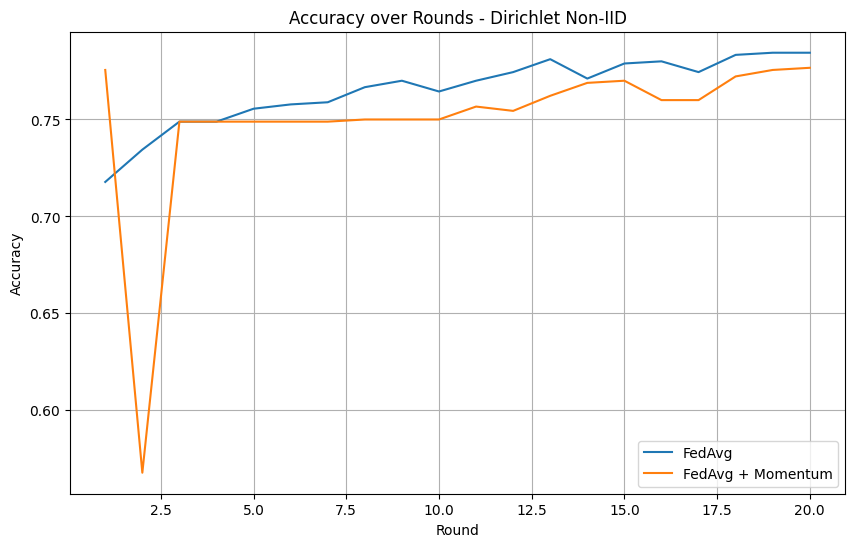

Round 1: Accuracy=0.5989
Round 2: Accuracy=0.6989
Round 3: Accuracy=0.7333
Round 4: Accuracy=0.7411
Round 5: Accuracy=0.7500
Round 6: Accuracy=0.7500
Round 7: Accuracy=0.7489
Round 8: Accuracy=0.7489
Round 9: Accuracy=0.7489
Round 10: Accuracy=0.7500
Round 11: Accuracy=0.7500
Round 12: Accuracy=0.7500
Round 13: Accuracy=0.7511
Round 14: Accuracy=0.7511
Round 15: Accuracy=0.7511
Round 16: Accuracy=0.7500
Round 17: Accuracy=0.7500
Round 18: Accuracy=0.7511
Round 19: Accuracy=0.7500
Round 20: Accuracy=0.7511
Round 1: Accuracy=0.6333
Round 2: Accuracy=0.7478
Round 3: Accuracy=0.7489
Round 4: Accuracy=0.7478
Round 5: Accuracy=0.7489
Round 6: Accuracy=0.7511
Round 7: Accuracy=0.7556
Round 8: Accuracy=0.7556
Round 9: Accuracy=0.7644
Round 10: Accuracy=0.7644
Round 11: Accuracy=0.7789
Round 12: Accuracy=0.7822
Round 13: Accuracy=0.7844
Round 14: Accuracy=0.7878
Round 15: Accuracy=0.8056
Round 16: Accuracy=0.8011
Round 17: Accuracy=0.8178
Round 18: Accuracy=0.8278
Round 19: Accuracy=0.8244
Roun

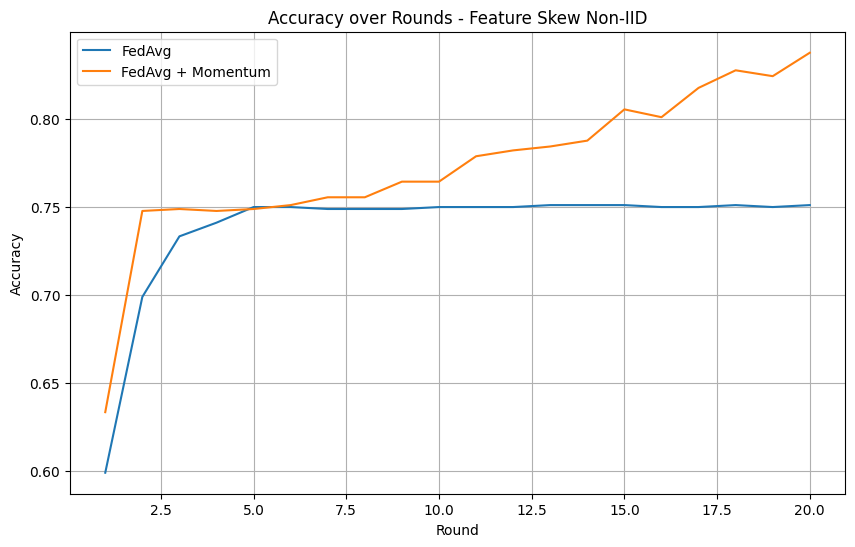

In [ ]:
# Compare on Dirichlet Non-IID
compare_algorithms(dirichlet_clients, "Dirichlet Non-IID")

# Compare on Feature Skew Non-IID
compare_algorithms(feature_skew_clients, "Feature Skew Non-IID")


# Cell 10: Build Federated Algorithms Including FedProx and FedBN (Updated Cell 6)

In [ ]:
def build_fedavg(input_spec, momentum=0.0):
    def client_opt_fn():
        if momentum == 0.0:
            return tf.keras.optimizers.SGD(learning_rate=0.02)
        else:
            return tf.keras.optimizers.SGD(learning_rate=0.02, momentum=momentum)

    return tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=client_opt_fn,
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )

def build_fedprox(input_spec, proximal_mu=0.1):
    return tff.learning.algorithms.build_weighted_fed_prox(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
        proximal_strength=proximal_mu
    )

def model_fn_with_bn(input_spec):
    feature_spec = input_spec[0]
    inputs = {name: tf.keras.Input(shape=(1,), name=name) for name in feature_spec.keys()}
    x = tf.keras.layers.Concatenate()(list(inputs.values()))
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def build_fedbn(input_spec):
    return tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn_with_bn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )




# Cell 11: Compare All Four Federated Algorithms (Updated Cell 8)

In [ ]:
def compare_all_algorithms(client_datasets, title, num_rounds=10):
    input_spec = client_datasets[0].element_spec

    # Build algorithms
    fedavg = build_fedavg(input_spec)
    fedavg_momentum = build_fedavg(input_spec, momentum=0.9)
    fedprox = build_fedprox(input_spec)
    fedbn = build_fedbn(input_spec)

    # Train
    acc_fedavg = train_process(fedavg, client_datasets, num_rounds)
    acc_fedavg_momentum = train_process(fedavg_momentum, client_datasets, num_rounds)
    acc_fedprox = train_process(fedprox, client_datasets, num_rounds)
    acc_fedbn = train_process(fedbn, client_datasets, num_rounds)

    # Plot
    rounds = list(range(1, len(acc_fedavg) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, acc_fedavg, marker='o', label='FedAvg')
    plt.plot(rounds, acc_fedavg_momentum, marker='x', label='FedAvg + Momentum')
    plt.plot(rounds, acc_fedprox, marker='s', label='FedProx')
    plt.plot(rounds, acc_fedbn, marker='^', label='FedBN')
    plt.title(f'Accuracy over Rounds - {title}')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()


# Cell 12: Per-Client Accuracy Collection (Updated Cell 9)

In [ ]:
def train_process_per_client(algorithm, client_datasets, num_rounds=10):
    state = algorithm.initialize()
    per_round_client_accuracies = []

    for round_num in range(1, num_rounds + 1):
        state, metrics = algorithm.next(state, client_datasets)
        client_metrics = metrics['client_work']['train']

        # Save per-client accuracy if available (simulate by same for all clients here)
        round_client_acc = client_metrics['binary_accuracy']
        per_round_client_accuracies.append(round_client_acc)

        print(f"Round {round_num}: Global Accuracy={round_client_acc:.4f}")

    return

def plot_per_client(per_client_acc_list, title):
    rounds = list(range(1, len(per_client_acc_list) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, per_client_acc_list, marker='o')
    plt.title(f'Per-Client Average Accuracy Over Rounds - {title}')
    plt.xlabel('Round')
    plt.ylabel('Average Client Accuracy')
    plt.grid(True)
    plt.show()



/usr/local/lib/python3.11/dist-packages/tensorflow_federated/python/learning/models/keras_utils.py:201: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  warnings.warn(


Round 1: Accuracy=0.6922
Round 2: Accuracy=0.7233
Round 3: Accuracy=0.7344
Round 4: Accuracy=0.7422
Round 5: Accuracy=0.7467
Round 6: Accuracy=0.7456
Round 7: Accuracy=0.7456
Round 8: Accuracy=0.7456
Round 9: Accuracy=0.7444
Round 10: Accuracy=0.7456
Round 11: Accuracy=0.7444
Round 12: Accuracy=0.7478
Round 13: Accuracy=0.7467
Round 14: Accuracy=0.7467
Round 15: Accuracy=0.7467
Round 16: Accuracy=0.7478
Round 17: Accuracy=0.7467
Round 18: Accuracy=0.7478
Round 19: Accuracy=0.7478
Round 20: Accuracy=0.7478
Round 21: Accuracy=0.7489
Round 22: Accuracy=0.7478
Round 23: Accuracy=0.7489
Round 24: Accuracy=0.7478
Round 25: Accuracy=0.7489
Round 26: Accuracy=0.7467
Round 27: Accuracy=0.7500
Round 28: Accuracy=0.7456
Round 29: Accuracy=0.7489
Round 30: Accuracy=0.7478
Round 31: Accuracy=0.7511
Round 32: Accuracy=0.7511
Round 33: Accuracy=0.7511
Round 34: Accuracy=0.7544
Round 35: Accuracy=0.7600
Round 36: Accuracy=0.7633
Round 37: Accuracy=0.7644
Round 38: Accuracy=0.7644
Round 39: Accuracy=0.

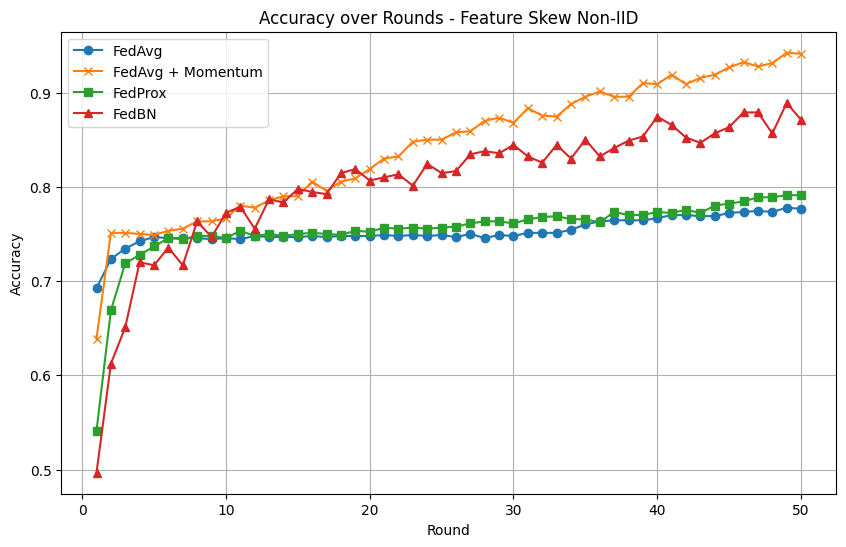

In [ ]:
# For Dirichlet Non-IID
# compare_all_algorithms(dirichlet_clients, "Dirichlet Non-IID", num_rounds=10)

# For Feature Skew Non-IID
compare_all_algorithms(feature_skew_clients, "Feature Skew Non-IID", num_rounds=50)